In [1]:
import numpy as np
import torch as th


from glob import glob
from utils import *
import ray
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ray.init(num_cpus=160, ignore_reinit_error=True)

2023-09-12 10:57:22,261	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.3
Ray version:,2.6.2
Dashboard:,http://127.0.0.1:8265


In [3]:
insmp = Backtester(20190103, 20210101, pattern = "./checkpoints/*sat*/",)
otsmp = Backtester(20210101, 20211231, pattern = "./checkpoints/*sat*/",)

num of factors:265
num of factors:265


In [4]:
factors = insmp.calc_factor()
factors2 = otsmp.calc_factor()

In [ ]:
df_ic = insmp.calc_ic()
df_ic2 = otsmp.calc_ic()


calc_ic took 958 seconds
calc_ic took 503 seconds


In [ ]:
ic_filter_idx = otsmp.df_ic.query("y1>0.01 and y2>0.01 and y5>0.01 and @insmp.df_ic.y1>.01 and @insmp.df_ic.y2>.015 and @insmp.df_ic.y5>.02").index

In [ ]:
feature_dict = dict(zip(otsmp.factor_names,otsmp.factors))

In [ ]:
ic_filter_sigs = [feature_dict[i] for i in ic_filter_idx]

In [ ]:
# def calc_sig_corr(sigs):
#     n = len(sigs)
#     df_corr = np.ones((n,n))
#     for i in range(n):
#         for j in range(i+1,n):
#             ic = torch.nanmean(batch_pearsonr(sigs[i],sigs[j],))
#             df_corr[i,j] = ic
#             df_corr[j,i] = ic
#     return df_corr
from concurrent.futures import ProcessPoolExecutor
            
def calc_single_corr(i, j, sigs):
    return torch.nanmean(batch_pearsonr(sigs[i], sigs[j]))

def calc_sig_corr(sigs):
    n = len(sigs)
    df_corr = np.ones((n, n))
    
    with ProcessPoolExecutor() as executor:
        future_to_index = {(i, j): executor.submit(calc_single_corr, i, j, sigs) for i in range(n) for j in range(i+1, n)}
        
        for (i, j), future in future_to_index.items():
            ic = future.result()
            df_corr[i, j] = ic
            df_corr[j, i] = ic
            
    return df_corr

In [ ]:
df_corr = calc_sig_corr(ic_filter_sigs)

In [ ]:
df_corr = pd.DataFrame(df_corr)

In [ ]:
lowcorr_idx = remove_high_corr_factors(df_corr.values)
print(len(lowcorr_idx))

112


In [ ]:
final = [ic_filter_idx[idx] for idx in lowcorr_idx]

In [ ]:

# 设置显示最大列数
pd.set_option('display.max_columns', None)

# 设置显示最大行数
pd.set_option('display.max_rows', None)
finaldf =  otsmp.df_ic.loc[final]

In [ ]:
finaldf.describe()

,y1,y2,y5
count,112.000000,112.000000,112.000000
mean,0.022771,0.024621,0.027917
std,0.006365,0.006607,0.008225
min,0.010023,0.011148,0.011538
25%,0.017724,0.019340,0.021048
50%,0.023028,0.024686,0.028593
75%,0.026749,0.029230,0.034207
max,0.036356,0.039204,0.047202


In [ ]:
fs  = ic_filter_sigs
y1d = otsmp.calter.ret1d
y2d = otsmp.calter.ret2d
y5d = otsmp.calter.ret5d

In [ ]:
finaldf

,y1,y2,y5
20230811171800_satd_lexpr08_lopt34_10_0042,0.029813,0.032791,0.039772
20230813143935_satd_lexpr08_lopt34_10_0322,0.011760,0.013922,0.012883
20230813145451_satd_lexpr08_lopt34_10_0856,0.026628,0.030035,0.037093
20230813145501_satd_lexpr08_lopt34_10_0726,0.029509,0.029523,0.031023
20230814092613_satd_lexpr08_lopt34_10_0788,0.030111,0.031117,0.033647
20230814092614_satd_lexpr08_lopt34_10_0177,0.010296,0.011239,0.015462
20230814092615_satd_lexpr08_lopt34_10_0018,0.021988,0.023256,0.023869
20230814092615_satd_lexpr08_lopt34_10_0143,0.022127,0.025572,0.027143
20230814102408_satd_lexpr15_lopt34_10_0319,0.026133,0.027363,0.035816
20230814175115_satd_lexpr15_lopt34_10_0852,0.035037,0.036416,0.041725


In [ ]:
finaldf.to_csv('result.csv')

In [ ]:
df_corr.iloc[lowcorr_idx,lowcorr_idx].to_csv('df_corr.csv')

In [ ]:
df_corr.replace(1,0).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.382538,0.341732,0.519182,0.528500,0.319034,0.439237,0.234517,0.477431,0.350183,0.384518,0.290599,0.517691,0.517029,0.547924,0.527960,0.372909,0.500804,0.389491,0.536434,0.491325,0.541092,0.561488,0.424687,0.338539,0.360706,0.522358,0.493768,0.506978,0.147954,0.535291,0.560000,0.443889,0.330599,0.396671,0.548731,0.524030,0.433773,0.569393,0.190950,0.399739,0.520160,0.368616,0.556783,0.558197,0.341253,0.364307,0.532594,0.427217,0.461180,0.545870,0.356135,0.480386,0.414922,0.285806,0.404149,0.380998,0.413549,0.444334,0.476984,0.355210,0.313781,0.347625,0.409332,0.456167,0.553837,0.435774,0.380283,0.523916,0.237306,0.393397,0.193685,0.431780,0.362026,0.188479,0.549671,0.215784,0.555491,0.387117,0.342598,0.153232,0.457878,0.538026,0.432349,0.565843,0.405399,0.298761,0.209445,0.227833,0.401979,0.419550,0.431285,0.486268,0.403203,0.311318,0.545909,0.348775,0.410041,0.510036,0.549285,0.344010,0.464424,0.440533,0.206155,0.516168,0.453079,0.341058,0.406198,0.295751,0.550029,0.521450,0.402871,0.197682,0.468340,0.530697,0.461747,0.373680,0.476290,0.333804,0.388344,0.378952,0.352812,0.530158,0.392214,0.203701,0.269088,0.377575,0.380592,0.502168,0.502206,0.541159,0.511739,0.551672,0.538400,0.413824,0.577257,0.472321,0.340369,0.365854,0.358576,0.388723,0.438809,0.178900,0.535729,0.323178,0.352834,0.527392,0.333068,0.355898,0.509061,0.375980,0.387355,0.504259,0.242429,0.358783,0.557387,0.367312,0.547387,0.297844
std,0.178905,0.146901,0.162752,0.176209,0.099028,0.146849,0.182322,0.154689,0.148886,0.114026,0.139034,0.198059,0.166846,0.200358,0.155073,0.168124,0.167175,0.129735,0.175303,0.172025,0.185581,0.168387,0.132404,0.121927,0.138522,0.181930,0.138232,0.162034,0.107162,0.176649,0.174936,0.139079,0.176598,0.131

In [ ]:
len(finaldf)

112

In [ ]:
import SharedArray as sa
qsize = sa.attach('qsize')

In [ ]:
import bottleneck as bk
for day in  range(qsize.shape[0]):
    ti=0
    print(f"day:{day} ti:{ti} mean:{bk.nanmean(qsize[day,ti]):.3f} std:{bk.nanstd(qsize[day,ti]):.3f} max:{bk.nanmax(qsize[day,ti]):.3f} min:{bk.nanmin(qsize[day,ti]):.3f}")

day:0 ti:0 mean:21.987 std:1.109 max:27.969 min:19.395
day:1 ti:0 mean:21.982 std:1.110 max:27.969 min:19.395
day:2 ti:0 mean:22.007 std:1.110 max:27.982 min:19.395
day:3 ti:0 mean:22.028 std:1.107 max:27.977 min:19.395
day:4 ti:0 mean:-0.000 std:1.000 max:5.365 min:-2.376
day:5 ti:0 mean:-0.000 std:1.000 max:5.370 min:-2.379
day:6 ti:0 mean:0.000 std:1.000 max:5.370 min:-2.380
day:7 ti:0 mean:-0.000 std:1.000 max:5.376 min:-2.392
day:8 ti:0 mean:-0.000 std:1.000 max:5.366 min:-2.383
day:9 ti:0 mean:0.000 std:1.000 max:5.356 min:-2.392
day:10 ti:0 mean:0.000 std:1.000 max:5.359 min:-2.389
day:11 ti:0 mean:-0.000 std:1.000 max:5.356 min:-2.373
day:12 ti:0 mean:0.000 std:1.000 max:5.361 min:-2.374
day:13 ti:0 mean:-0.000 std:1.000 max:5.369 min:-2.382
day:14 ti:0 mean:0.000 std:1.000 max:5.381 min:-2.380
day:15 ti:0 mean:-0.000 std:1.000 max:5.393 min:-2.384
day:16 ti:0 mean:0.000 std:1.000 max:5.394 min:-2.389
day:17 ti:0 mean:-0.000 std:1.000 max:5.385 min:-2.370
day:18 ti:0 mean:-0.00

In [1]:
from alphagen.utils.correlation import batch_pearsonr

In [5]:
import torch as th
a = th.randn(512,1).T
b = th.randn(512,1).T
batch_pearsonr(a,b)

tensor([-0.0368])

In [30]:
from alphagen_ocean.stock_data import FakeData

In [31]:
import numpy as np

In [32]:
from alphagen_ocean.calculator_t0 import Calculator_t0

In [33]:
calt = Calculator_t0()

-------ret1d--------
tensor([[  -8.0225],
        [  -8.0225],
        [   0.0000],
        ...,
        [-123.0336],
        [ -93.7019],
        [ -99.9800]], device='cuda:0')


In [34]:
data = calt.data

c:\Users\WY\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

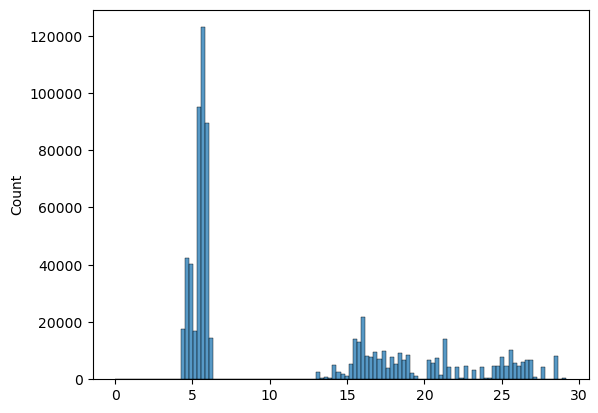

In [41]:
import seaborn as sns
sns.histplot(data.data[1:1231231,2])

In [15]:
from alphagen.data.expression import *

In [10]:
expr = Constant(12)

In [11]:
expr.evaluate(data)

tensor([[12.],
        [12.],
        [12.],
        ...,
        [12.],
        [12.],
        [12.]], device='cuda:0')

In [20]:
expr = Max(12.3,5)

In [21]:
expr.evaluate(data)

tensor([[12.3000],
        [12.3000],
        [12.3000],
        ...,
        [12.3000],
        [12.3000],
        [12.3000]], device='cuda:0')

In [23]:
from alphagen_ocean.stock_data import FeatureType,FEATURES